# Exercise 4.1: Solve MNIST classification with a CNN

Advanced Machine Learning for KCS

by Stefan Heinrich, Stella Grasshof, Laura Weihl
with material by Kevin Murphy

All info and static material: https://learnit.itu.dk/course/view.php?id=3021295

-------------------------------------------------------------------------------

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

#### Load MNIST or fashion MNIST from tensorflow or pytorch

In [17]:
batch_size = 32

In [18]:
# transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# Create a dataloader for Pytorch training
# download and load training dataset
#trainset = torchvision.datasets.FashionMNIST(root='../data', train=True,
                                        #download=True, transform=transform)
trainset = torchvision.datasets.MNIST(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# download and load testing dataset
#testset = torchvision.datasets.FashionMNIST(root='../data', train=False,
                                       #download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)


##### Data Splitting

In [19]:
# as an alternative you can further split the training data to obtain a validation set:

#trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                          shuffle=True, num_workers=2)
#valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
#                                          shuffle=True, num_workers=2)

##### Preprocessing

In [20]:
print(len(trainset))
#print(len(valset))
print(len(testset))
img_size = trainloader.dataset.data.shape[1]
print(img_size)
class_out = trainloader.dataset.targets.unique().size()[0]
print(class_out)

60000
10000
28
10


##### Show some data characteristics

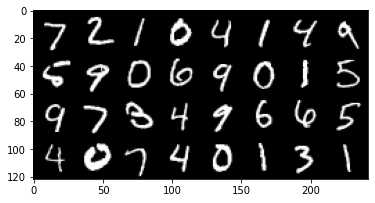

In [21]:
NO_images = 32

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images = []
for _ in range(NO_images):
    # draw some random images from the test set according to the dataloader
    image, label = next(dataiter)
    image = torch.squeeze(image, 0)
    images.append(image)

images = torch.stack(images).cpu()

# print images
imshow(torchvision.utils.make_grid(images))

#### Build the model

Important parameters:

**in_channels (int)** — Number of channels in the input image

**out_channels (int)** — Number of channels produced by the convolution

**kernel_size (int or tuple)** — Size of the convolving kernel

**stride (int or tuple, optional)** — Stride of the convolution. Default: 1

**padding (int or tuple, optional)** — Zero-padding added to both sides of the input. Default: 0

**padding_mode (string, optional)** — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’

**groups (int, optional)** — Number of blocked connections from input channels to output channels. Default: 1

**bias (bool, optional)** — If True, adds a learnable bias to the output. Default: True

In [22]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu") # Mac with metal

def get_output_shape(layer, img_size):
    return layer(torch.rand(*(img_size))).data.shape

class ModelClass(nn.Module):
  def __init__(self, img_size, fc1_out, class_out):
      super(ModelClass, self).__init__()

      self.conv_layer = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
      flatten_size_conv_layer = np.prod(list(get_output_shape(self.conv_layer, (batch_size, 1, img_size, img_size)))) // batch_size

      self.linear_layer_1 = nn.Linear(in_features=flatten_size_conv_layer, out_features=fc1_out)
      self.linear_layer_2 = nn.Linear(in_features=fc1_out, out_features=class_out)

  def forward(self, img):

    img = self.conv_layer(img)
    img = F.relu(img)

    #Start_dim = 1 because we pass batches
    flattened = img.flatten(start_dim=1)

    x = self.linear_layer_1(flattened)
    x = F.relu(x)

    x = self.linear_layer_2(x)
    x = F.softmax(x, dim=1)

    return x

model = ModelClass(img_size, 128, class_out)
model = model.to(device)
print(model)  # print the architecture

#for param in model.parameters():  # you can use this to plot the actual weights/parameters
#    print(param)

ModelClass(
  (conv_layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (linear_layer_1): Linear(in_features=21632, out_features=128, bias=True)
  (linear_layer_2): Linear(in_features=128, out_features=10, bias=True)
)


#### Train the model

In [23]:
learning_rate = 0.001
momentum = 0.9
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [24]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

##### Training loop

In [25]:
for epoch in range(epochs):
  #Put the model in training mode
  model = model.train()

  train_running_loss = 0.0
  train_acc = 0.0
  for idx, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)

    ## forward + backprop + loss
    logits = model(images)
    loss = criterion(logits, labels)
    optimizer.zero_grad()
    loss.backward()

    ## update model params
    optimizer.step()

    train_running_loss += loss.detach().item()
    train_acc += get_accuracy(logits, labels, batch_size)

  print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / idx, train_acc/idx))


Epoch: 0 | Loss: 1.9107 | Train Accuracy: 62.63
Epoch: 1 | Loss: 1.6313 | Train Accuracy: 84.80
Epoch: 2 | Loss: 1.5667 | Train Accuracy: 90.92
Epoch: 3 | Loss: 1.5535 | Train Accuracy: 91.82
Epoch: 4 | Loss: 1.5453 | Train Accuracy: 92.45
Epoch: 5 | Loss: 1.5388 | Train Accuracy: 93.09
Epoch: 6 | Loss: 1.5333 | Train Accuracy: 93.53
Epoch: 7 | Loss: 1.5285 | Train Accuracy: 94.02
Epoch: 8 | Loss: 1.5244 | Train Accuracy: 94.38
Epoch: 9 | Loss: 1.5206 | Train Accuracy: 94.73


##### Analyse some training progress

In [26]:
model = model.eval()
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, 1)

print(f"Test Accuracy: {test_acc/i}, in epoch: {epoch}")

Test Accuracy: 94.67946794679467, in epoch: 9


#### Analyse the model

In [27]:
model = model.eval()

hist = {
          0: {i:0 for i in range(10)},
          1: {i:0 for i in range(10)},
          2: {i:0 for i in range(10)},
          3: {i:0 for i in range(10)},
          4: {i:0 for i in range(10)},
          5: {i:0 for i in range(10)},
          6: {i:0 for i in range(10)},
          7: {i:0 for i in range(10)},
          8: {i:0 for i in range(10)},
          9: {i:0 for i in range(10)}
        }

logits = []

for (images, labels) in testloader:
  images = images.to(device)
  labels = labels.to(device)
  outputs = model(images)
  logits.append(outputs.tolist()[0])
  pred = torch.argmax(outputs).item()
  hist[labels[0].item()][pred] += 1

##### Histogram of predictions

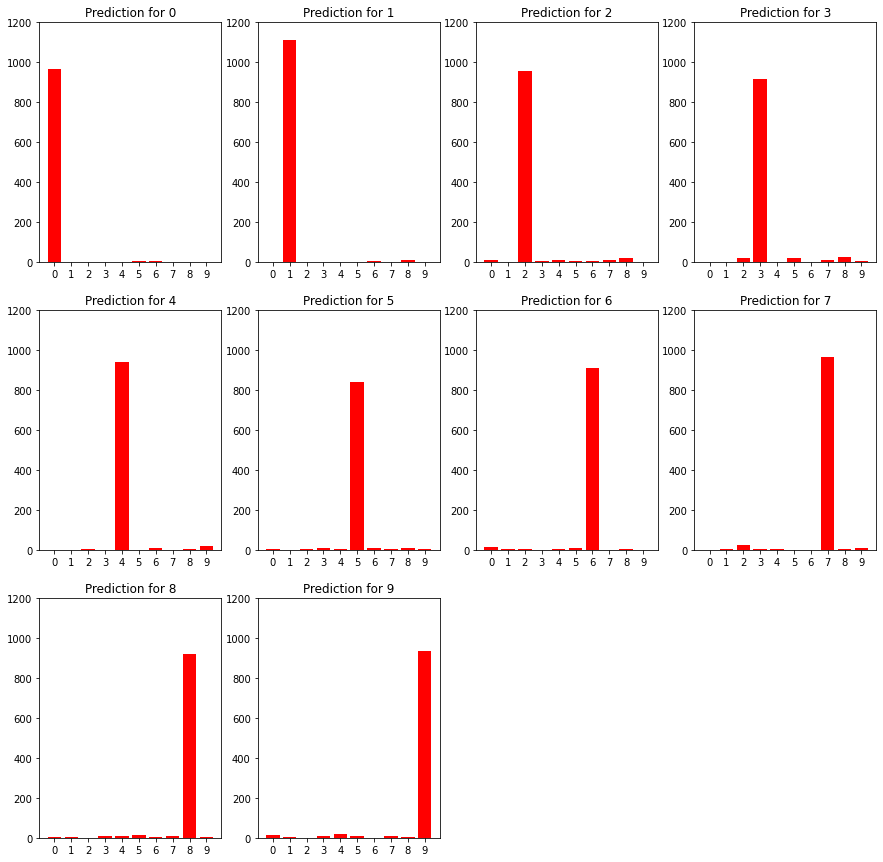

In [28]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
for idx, (key, val) in enumerate(hist.items()):
  ax = fig.add_subplot(3, 4, idx+1)
  ax.bar(list(val.keys()), val.values(), color='r')
  ax.set_title(f"Prediction for {key}")
  ax.set_xticks(range(0,10))
  ax.set_ylim(0, 1200)

plt.show()

We see it has gotten better in predicting 5 and 9 especially, while getting worse at 2 and 6.

This could be due to the difference in how it learns features of the data. 

##### Visualise some prediction structure

/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Predicted logits')

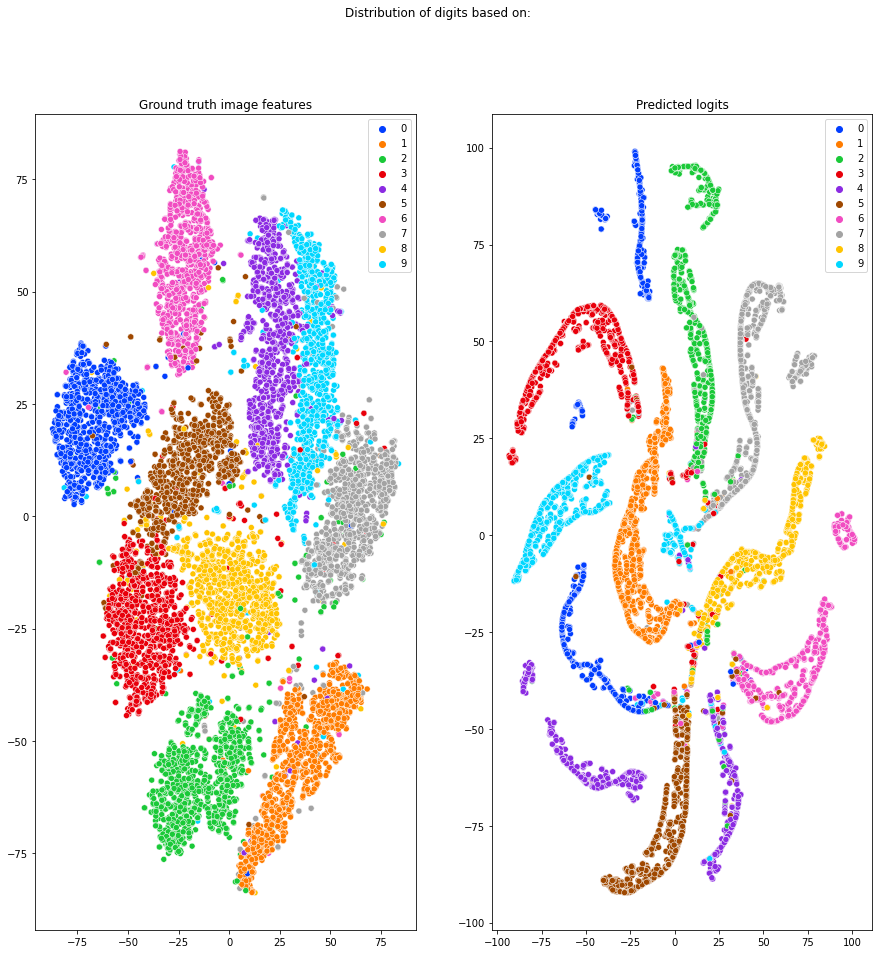

In [29]:
#tsne = TSNE(n_components=2, learning_rate='auto', init='pca')
tsne = TSNE()

palette = sns.color_palette("bright", 10)

y = testloader.dataset.targets.tolist()
X_embedded_true = tsne.fit_transform(torch.flatten(testloader.dataset.data,start_dim=1))
X_embedded_pred = tsne.fit_transform(np.array(logits))

fig, axes = plt.subplots(1, 2, figsize=(15, 15))
fig.suptitle('Distribution of digits based on: ')

sns.scatterplot(ax=axes[0], x=X_embedded_true[:,0], y=X_embedded_true[:,1], hue=y, legend='full', palette=palette)
axes[0].set_title("Ground truth image features")

sns.scatterplot(ax=axes[1], x=X_embedded_pred[:,0], y=X_embedded_pred[:,1], hue=y, legend='full', palette=palette)
axes[1].set_title("Predicted logits")